In [10]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import tifffile

from pathlib import Path

%matplotlib inline
#%matplotlib notebook
#%matplotlib widget

import matplotlib.pyplot as plt
import gui
from math import ceil

In [11]:
def read_3d_volume(fileName, nx, ny, nz, dtype=np.float32):

    #print('Reading 3D volume file: ', fileName)
    f = open(fileName, "rb")
    data = np.fromfile(f, dtype=dtype)

    #size = nx*ny*nz
    shape = (nz, ny, nx)

    return data.reshape(shape)

In [14]:
def analyze_bubbles(dataset, param, frame, verbose=False):
    
    print()
    print(f'Dataset: {dataset}, param: {param}, frame: {frame}')
    # Load data
    if verbose:
        print("Loading data")
        
        
    if dataset == 'GFD' and param == '100':
        fix = '_bis'
    else:
        fix = ''
        
    #vol = tifffile.imread(str(data_path / f'{dataset}_tomo{frame}.tif'))
    #labels = tifffile.imread(str(labels_path / f'{dataset}_tomo{frame}.tif'))
    #electr_mask = tifffile.imread(str(masks_path / f'{dataset}_electr.tif'))
    
    vol_path = input_path / experiment / f"{dataset}_{param}mV{fix}" / f"{dataset}_{param}mV{fix}_tomo_{frame}-slices-pr_scaled2_8bit_align_v2.tif"
    vol = tifffile.imread(str(vol_path))
    
    labels_path = input_path / experiment / f"{dataset}_{param}mV{fix}" / f"segmented_{dataset}_{param}mV{fix}_tomo_{frame}-slices-pr_scaled2_8bit_align_v2.tif"
    labels = tifffile.imread(str(labels_path))
    
    electr_mask_path = masks_path / f'{dataset}_electr.raw'
    electr_mask = read_3d_volume(electr_mask_path, nx, ny, nz, np.uint8)
    electr_mask = electr_mask / 255
    
    # Crop data
    
    cr = crop_info[dataset]
    vol = vol[cr['z1']:cr['z2'],cr['y']:cr['y']+cr['h'],cr['x']:cr['x']+cr['w']]
    labels = labels[cr['z1']:cr['z2'],cr['y']:cr['y']+cr['h'],cr['x']:cr['x']+cr['w']]
    electr_mask = electr_mask[cr['z1']:cr['z2'],cr['y']:cr['y']+cr['h'],cr['x']:cr['x']+cr['w']]
    
    
    # Process labels
    if verbose:
        print("Processing labels")   
        
    air = labels.copy()
    air[air != 1] = 0
    
    vol_img = sitk.GetImageFromArray(vol.astype(np.uint8))
    electr_img = sitk.GetImageFromArray(electr_mask.astype(np.uint8))
    
    # Mask bubbles by the electrode mask
    masked_bubbles_img = electr_img * sitk.GetImageFromArray(air.astype(np.uint8))

    # Remove small bubbles using morphological filtering
    if verbose:
        print("Cleaning data")
    m = 3
    cleaned_bubbles_img = sitk.BinaryOpeningByReconstruction(masked_bubbles_img, [m, m, m])
    cleaned_bubbles_img = sitk.BinaryClosingByReconstruction(cleaned_bubbles_img, [m, m, m])
    
    # Measure electrode
    stats = sitk.LabelShapeStatisticsImageFilter()
    parts_img = sitk.ConnectedComponent(electr_img)
    stats.Execute(parts_img)

    label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 0]
    
    if verbose:
        print("Electrode parts sizes: ", label_sizes)
    
    # Extract electrode as the largest component
    largest_component_label= np.argmax(np.array(label_sizes))
    electr_volume = label_sizes[largest_component_label]
    
    
    # Quantify bubbles
    if verbose:
        print("Quantifing bubbles")
        
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.ComputeOrientedBoundingBoxOn()
    bubbles_img = sitk.ConnectedComponent(cleaned_bubbles_img)
    stats.Execute(bubbles_img)

    # Look at the distribution of sizes of connected components (bacteria).
    bubble_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 0]
    
    if verbose:
        print("Bubble sizes: ", bubble_sizes)
        
        
    # Save data
    if verbose:
        print("Saving bubbles data")
    bubbles_path = input_path / experiment / f"{dataset}_{param}mV{fix}" / f"bubbles_{dataset}_{param}mV{fix}_tomo_{frame}-slices-pr_scaled2_8bit_align_v2.tif"
    bubbles_img = sitk.Cast(bubbles_img, sitk.sitkUInt16)

    sitk.WriteImage(bubbles_img, str(bubbles_path))
    
    # Measure volume fraction
    bubbles_volume = np.sum(np.array(bubble_sizes))
    volume_fraction = bubbles_volume / electr_volume
    #print('Volume fraction: ', volume_fraction*100)
    
    measures = {}
    measures['volume_fraction'] = volume_fraction
    measures['bubbles_volume'] = bubbles_volume
    measures['electrode_volume'] = electr_volume 
    
    # Extract bubble statistics
    stats_list = [ (stats.GetPhysicalSize(i),
               stats.GetElongation(i),
               stats.GetFlatness(i),
               stats.GetRoundness(i),
               stats.GetOrientedBoundingBoxSize(i)[0],
               stats.GetOrientedBoundingBoxSize(i)[2],
               stats.GetCentroid(i)[0],
               stats.GetCentroid(i)[1],
               stats.GetCentroid(i)[2],
                
               ) for i in stats.GetLabels()]
    cols=["Volume (pixels)",
          "Elongation",
          "Flatness",
          "Roundness",
          "OBB Minimum Size (pixels)",
          "OBB Maximum Size (pixels)",
          "CentrX",
          "CentrY",
          "CentrZ"
         ]

    # Create the pandas data frame and display descriptive statistics.
    bubbles_stats = pd.DataFrame(data=stats_list, index=stats.GetLabels(), columns=cols)
    
    if verbose:
        print('Finished!')
    
    return measures, bubbles_stats


def save_measures(file_path, measures):
    
    text_file = open(file_path, "w")
    text_file.write(f"volume_fraction: {measures['volume_fraction']}\n")
    text_file.write(f"bubbles_volume: {measures['bubbles_volume']}\n")
    text_file.write(f"electrode_volume: {measures['electrode_volume']}\n")
    text_file.close()
    

In [13]:
input_path = Path('Z:\\collaborations\\ulm-batteries\\processed\\A2021-031-019033\\')
results_path = 'analysis'
#input_path = Path('c:\\Users\\fe0968\\Documents\\data\\batteries\\segmentation')
#data_path = input_path / 'volumes'
#labels_path = input_path / 'labels'
masks_path = input_path / 'segmentation' / 'new_masks'

#datasets = ['GFA','GFD', 'GDL']
datasets = ['GFD']
params = ['100', '200', '300']

experiment = 'Experiment2_bis'
dataset = 'GFA'
param = '300'
frame = '01'

nx = 976
ny = 976
nz = 976

if dataset == 'GFD':
    fix = '_bis'
else:
    fix = ''
    
crop_info = {'GFA': {'z1': 200, 'z2':750, 'x': 175, 'w': 800, 'y':70, 'h':700},
             'GFD': {'z1': 200, 'z2':750, 'x': 175, 'w': 800, 'y':89, 'h':700},
             'GDL': {'z1': 200, 'z2':750, 'x': 147, 'w': 800, 'y':112, 'h':700}
            }

#cr = crop_info[dataset]

In [15]:
for dataset in datasets:
    for param in params:


        measures01, stats01 = analyze_bubbles(dataset, param, '01', True)
        measures02, stats02 = analyze_bubbles(dataset, param, '02', True)

        print()
        print('Volume fraction before: ', measures01['volume_fraction']*100)
        print('Volume fraction after potential: ', measures02['volume_fraction']*100)

        stats01.to_excel(input_path / experiment / results_path / f"{dataset}_{param}mV_tomo01_bubbles.xlsx") 
        stats02.to_excel(input_path / experiment / results_path / f"{dataset}_{param}mV_tomo02_bubbles.xlsx")

        save_measures(input_path / experiment / results_path / f"{dataset}_{param}mV_tomo01_measures.txt", measures01)
        save_measures(input_path / experiment / results_path / f"{dataset}_{param}mV_tomo02_measures.txt", measures02)


Dataset: GFD, param: 100, frame: 01
Loading data
Processing labels
Cleaning data
Electrode parts sizes:  [116825862, 3]
Quantifing bubbles
Bubble sizes:  [19365, 8529, 35694, 1722, 3021, 33104, 34501, 4139, 4738, 2326, 1176, 447, 21039, 4250, 11061, 26845, 1029, 3563, 2603, 7798]
Saving bubbles data
Finished!

Dataset: GFD, param: 100, frame: 02
Loading data
Processing labels
Cleaning data
Electrode parts sizes:  [116825862, 3]
Quantifing bubbles
Bubble sizes:  [3438, 9592, 8900, 3493, 4448, 9395, 4411, 3262, 832, 994, 3270, 2503]
Saving bubbles data
Finished!

Volume fraction before:  0.19426349278723917
Volume fraction after potential:  0.046683156508616215

Dataset: GFD, param: 200, frame: 01
Loading data
Processing labels
Cleaning data
Electrode parts sizes:  [116825862, 3]
Quantifing bubbles
Bubble sizes:  [1064, 8138, 3739, 626, 12954, 557440, 1292, 6659, 18446, 1802, 1230, 3464, 722, 5372, 68486, 1290, 11953, 2647, 2606, 354, 2170, 2350, 3572, 211870, 78015, 8270, 2108, 13890, 

In [77]:
print('Volume fraction before: ', measures01['volume_fraction']*100)
print('Volume fraction after potential: ', measures02['volume_fraction']*100)

Volume fraction before:  4.023319745836094
Volume fraction after potential:  34.440744697248434


In [78]:
stats01.to_excel(results_path / f"{dataset}_{param}mV_tomo01_bubbles.xlsx") 
stats02.to_excel(results_path / f"{dataset}_{param}mV_tomo02_bubbles.xlsx")

save_measures(results_path / f"{dataset}_{param}mV_tomo01_measures.txt", measures01)
save_measures(results_path / f"{dataset}_{param}mV_tomo02_measures.txt", measures02)

## Testing

In [8]:
#plt.imshow(vol[200])
#plt.show()


In [10]:
vol_path = input_path / experiment / f"{dataset}_{param}mV{fix}" / f"{dataset}_{param}mV{fix}_tomo_{frame}-slices-pr_scaled2_8bit_align_v2.tif"
vol = tifffile.imread(str(vol_path))

In [16]:
vol = vol[cr['z1']:cr['z2'],cr['y']:cr['y']+cr['h'],cr['x']:cr['x']+cr['w']]

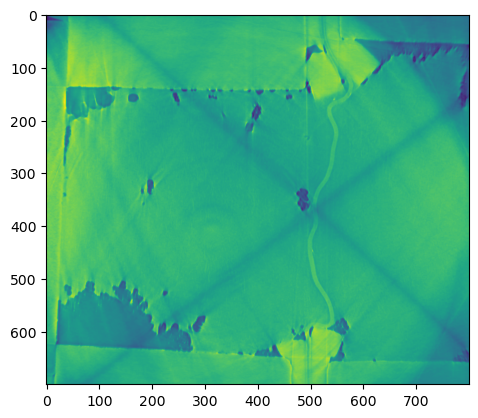

In [17]:
plt.imshow(vol[200])
#plt.show()

In [18]:
labels_path = input_path / experiment / f"{dataset}_{param}mV{fix}" / f"segmented_{dataset}_{param}mV{fix}_tomo_{frame}-slices-pr_scaled2_8bit_align_v2.tif"
labels = tifffile.imread(str(labels_path))

In [19]:
labels = labels[cr['z1']:cr['z2'],cr['y']:cr['y']+cr['h'],cr['x']:cr['x']+cr['w']]

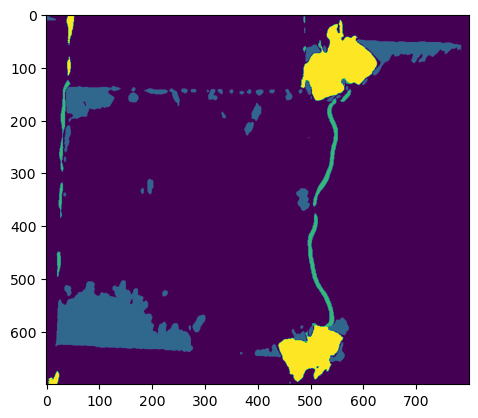

In [20]:
plt.imshow(labels[200])

In [45]:

electr_mask_path = masks_path / f'{dataset}_electr.raw'
electr_mask = read_3d_volume(electr_mask_path, nx, ny, nz, np.uint8)

In [46]:
electr_mask = electr_mask[cr['z1']:cr['z2'],cr['y']:cr['y']+cr['h'],cr['x']:cr['x']+cr['w']] / 255

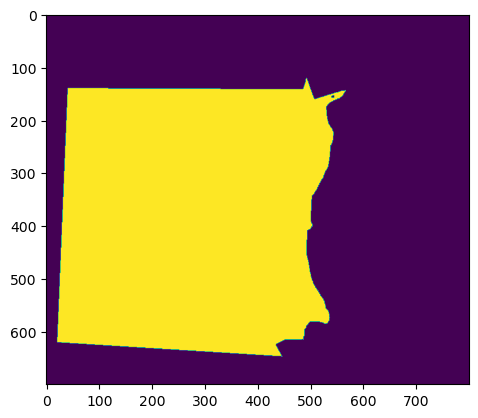

In [47]:
plt.imshow(electr_mask[200])

In [48]:
vol_img = sitk.GetImageFromArray(vol.astype(np.uint8))
electr_img = sitk.GetImageFromArray(electr_mask.astype(np.uint8))

In [49]:
air = labels.copy()
air[air != 1] = 0

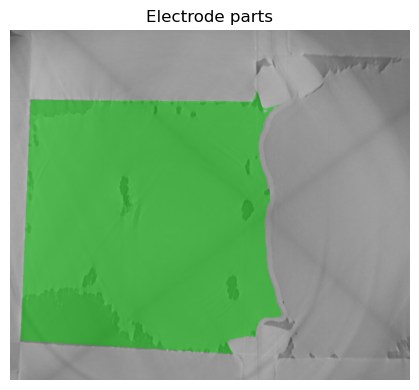

In [56]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, electr_img)],                   
                      title_list = ['Electrode parts'], figure_size=(8,4));

In [52]:
masked_bubbles_img = electr_img * sitk.GetImageFromArray(air.astype(np.uint8))

m = 3
cleaned_bubbles_img = sitk.BinaryOpeningByReconstruction(masked_bubbles_img, [m, m, m])
cleaned_bubbles_img = sitk.BinaryClosingByReconstruction(cleaned_bubbles_img, [m, m, m])

gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, masked_bubbles_img)],                   
                      title_list = ['Bubbles Segmentation'], figure_size=(8,4));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

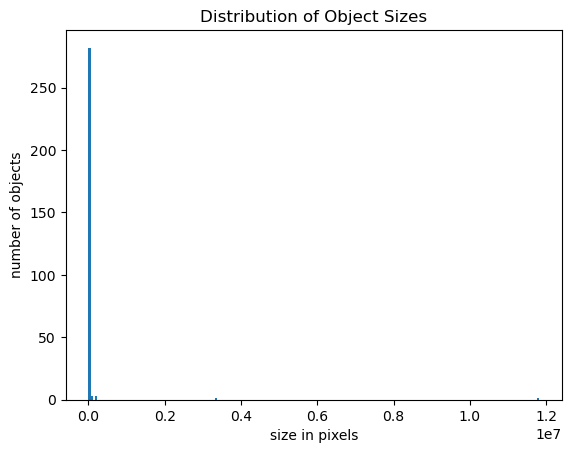

[3324158, 1591, 23448, 5229, 496, 11819305, 4066, 306, 235262, 4898, 2003, 3891, 46456, 3215, 2624, 5154, 4234, 744, 1280, 1938, 90467, 26074, 8822, 15232, 2864, 3827, 5042, 717, 10332, 3252, 5025, 1399, 70431, 3140, 26311, 21449, 4828, 1426, 882, 416, 110175, 11789, 2819, 1327, 24792, 19868, 20501, 3735, 3281, 7467, 1818, 4447, 1640, 3108, 4210, 2425, 395, 14033, 4886, 2922, 3106, 2839, 728, 430, 13672, 2050, 1377, 649, 1197, 1876, 530, 5467, 649, 7136, 3877, 664, 6442, 492, 6123, 7718, 36009, 324, 11430, 22835, 4670, 7602, 11110, 5494, 1463, 5330, 374, 4972, 926, 941, 3280, 5287, 18372, 1357, 1001, 20534, 534, 3728, 24853, 591, 2448, 1642, 179019, 19276, 26926, 2802, 6010, 6233, 1503, 3077, 1632, 10630, 59167, 1795, 320, 7511, 3221, 6841, 5301, 2930, 1726, 4052, 2040, 1620, 920, 3501, 15325, 593, 5823, 762, 28916, 1656, 525, 23924, 2979, 27771, 2157, 369, 1174, 9723, 2293, 33397, 2043, 3820, 4189, 1998, 3473, 1628, 2491, 4704, 1492, 1003, 1587, 6056, 1246, 1017, 36471, 3067, 15677, 4

In [57]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.ComputeOrientedBoundingBoxOn()
bubbles_img = sitk.ConnectedComponent(cleaned_bubbles_img)
stats.Execute(bubbles_img)

# Look at the distribution of sizes of connected components (bacteria).
bubble_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 0]

plt.figure()
plt.hist(bubble_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

print(bubble_sizes)

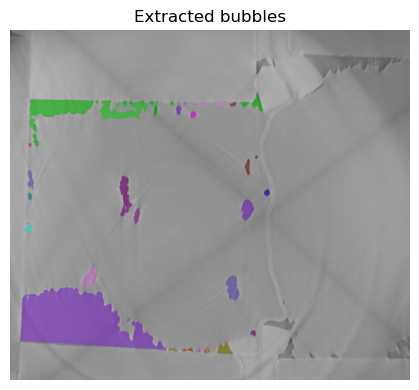

In [32]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, bubbles_img)],                   
                      title_list = ['Extracted bubbles'], figure_size=(8,4));

In [36]:
# Save data
bubbles_path = input_path / experiment / f"{dataset}_{param}mV{fix}" / f"bubbles_{dataset}_{param}mV{fix}_tomo_{frame}-slices-pr_scaled2_8bit_align_v2.tif"

bubbles_img = sitk.Cast(bubbles_img, sitk.sitkUInt16)

sitk.WriteImage(bubbles_img, str(bubbles_path))

In [35]:
print(bubbles_img.GetPixelIDTypeAsString())

32-bit unsigned integer


## Old code

In [36]:
air = labels.copy()
air[air != 1] = 0

mem = labels.copy()
mem[mem != 2] = 0
mem_bin = mem / 2
#tifffile.imwrite(input_path / f'mem_orig.tif', mem)
mem_img = sitk.GetImageFromArray(mem_bin.astype(np.uint8))
# Dilate membrane to remove small holes
m = 5
dilated_mem_img = sitk.BinaryDilate(mem_img, [m, m, m])
mem = sitk.GetArrayFromImage(dilated_mem_img)

#tifffile.imwrite(input_path / f'mem_close.tif', mem)

gask = labels.copy()
gask[gask != 3] = 0


In [37]:
electr = electr_mask / 255 - mem - gask/3
electr[electr<0] = 0

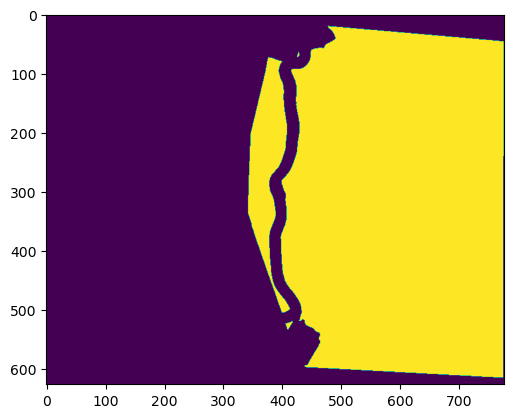

In [38]:
plt.imshow(electr[200])
plt.show()

In [39]:
vol_img = sitk.GetImageFromArray(vol.astype(np.uint8))
electr_img = sitk.GetImageFromArray(electr.astype(np.uint8))

# Separate parts
stats = sitk.LabelShapeStatisticsImageFilter()
parts_img = sitk.ConnectedComponent(electr_img)
stats.Execute(parts_img)

# Look at the distribution of sizes of connected components
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 0]

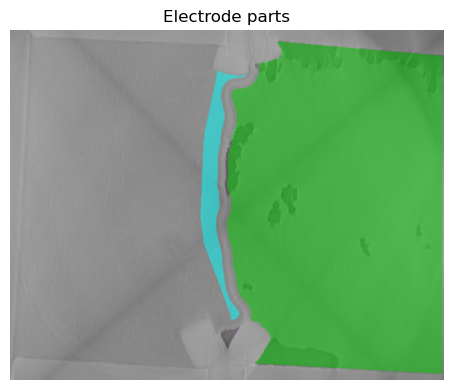

In [58]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, parts_img)],                   
                      title_list = ['Electrode parts'], figure_size=(8,4));

In [40]:
print(stats.GetLabels())

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41)


In [41]:
print(label_sizes)

[98723325, 100, 7055872, 19, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 34551, 9, 2, 3, 7, 5, 5, 1, 1, 1, 2, 2, 3, 4, 7, 2, 1, 1, 1, 1, 5, 4, 12, 1, 2, 1, 2114]


In [42]:
largest_component_label= np.argmax(np.array(label_sizes))
electr_volume = label_sizes[largest_component_label]
largest_component_binary_image = (parts_img == (largest_component_label+1))

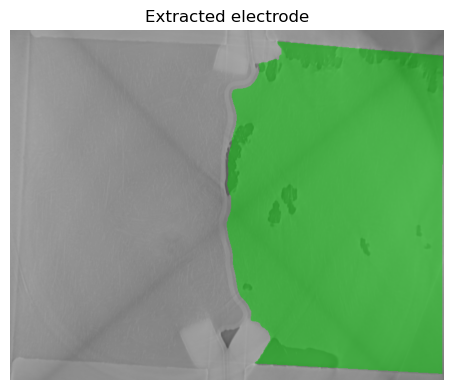

In [57]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, largest_component_binary_image)],                   
                      title_list = ['Extracted electrode'], figure_size=(8,4));

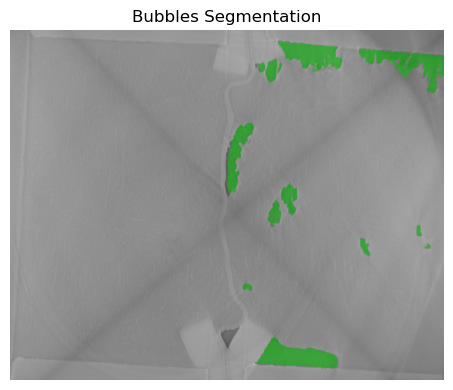

In [56]:
masked_bubbles_img = largest_component_binary_image * sitk.GetImageFromArray(air.astype(np.uint8))

m = 3
cleaned_bubbles_img = sitk.BinaryOpeningByReconstruction(masked_bubbles_img, [m, m, m])
cleaned_bubbles_img = sitk.BinaryClosingByReconstruction(cleaned_bubbles_img, [m, m, m])

gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, masked_bubbles_img)],                   
                      title_list = ['Bubbles Segmentation'], figure_size=(8,4));

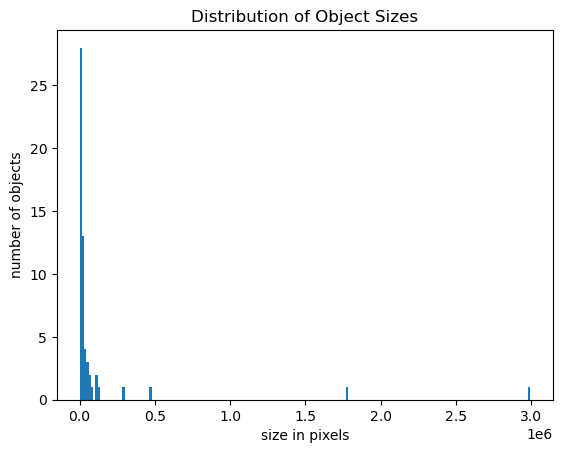

In [45]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.ComputeOrientedBoundingBoxOn()
bubbles_img = sitk.ConnectedComponent(cleaned_bubbles_img)
stats.Execute(bubbles_img)

# Look at the distribution of sizes of connected components (bacteria).
bubble_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 0]

plt.figure()
plt.hist(bubble_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

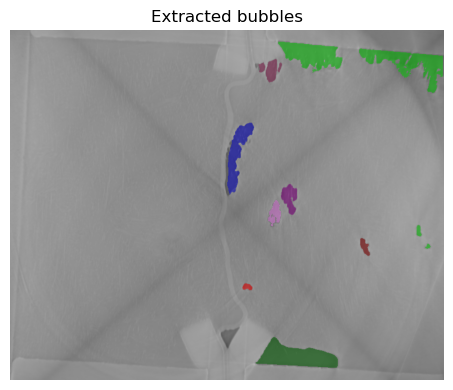

In [59]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(vol_img, bubbles_img)],                   
                      title_list = ['Extracted bubbles'], figure_size=(8,4));

In [46]:
print(bubble_sizes)

[2993389, 531, 7929, 116681, 11019, 1774342, 24401, 18880, 13612, 2626, 22654, 4358, 13776, 130929, 17668, 46788, 10949, 9714, 473002, 33763, 10025, 15105, 26389, 9057, 105358, 23292, 21759, 19543, 7982, 16993, 32690, 69481, 6597, 26646, 1939, 287310, 1784, 3025, 15849, 9947, 34972, 57309, 1741, 1662, 3026, 539, 13725, 28281, 1763, 40918, 4004, 68427, 50339, 1353, 24225, 81509, 11088, 392]


In [37]:
print(bubble_sizes)

[3322958, 123, 1591, 23438, 5229, 496, 11818120, 4066, 306, 235258, 14, 82, 33, 104, 4, 1, 1, 4898, 57, 1, 2, 66, 2003, 1, 1, 2, 3891, 46456, 1, 3215, 1, 2624, 45, 5154, 4234, 18, 2, 744, 19, 192, 1, 2, 1280, 291, 4, 1938, 148, 30, 3, 82, 3, 1, 4, 3, 90459, 26074, 58, 8822, 213, 15232, 864, 33, 2864, 1, 1, 1, 1, 1, 3827, 5042, 78, 422, 717, 9, 1, 1, 20, 1, 4, 1, 1, 2673, 3, 10332, 272, 5, 2, 3252, 92, 1, 5025, 135, 2, 81, 1399, 13, 70406, 3140, 5, 26311, 27, 3, 32, 1, 1, 1, 3, 10, 51, 23, 1, 86, 614, 7, 11, 23, 24, 21449, 223, 1, 4828, 12, 1, 1, 35, 1426, 882, 416, 30, 20, 1, 26, 3, 110175, 11789, 5, 129, 1, 23, 2819, 36, 91, 30, 1, 1327, 31, 24, 47, 6, 1, 3, 1, 24792, 2, 19868, 11, 2, 13, 2, 203, 189, 120, 2, 4, 7, 20501, 15, 39, 1, 3735, 181, 21, 2, 111, 113, 11, 1, 25, 56, 65, 3281, 2, 7467, 41, 6, 17, 16, 2, 3, 1818, 145, 2, 2, 79, 13, 5, 5, 4447, 27, 1640, 401, 1, 1, 125, 5, 10, 388, 9, 20, 1, 3, 3108, 1, 19, 7, 4210, 14, 136, 36, 2425, 174, 57, 1, 11, 1, 4, 2, 85, 395, 14030, 488

In [50]:
volume_fraction = np.sum(np.array(bubble_sizes)) / electr_volume
print('Volume fraction: ', volume_fraction*100)

Volume fraction:  6.9518069817847


In [29]:
volume_fraction = np.sum(np.array(bubble_sizes)) / electr_volume
print('Volume fraction: ', volume_fraction*100)

Volume fraction:  56.635938872601784


In [51]:
stats_list = [ (stats.GetPhysicalSize(i),
               stats.GetElongation(i),
               stats.GetFlatness(i),
               stats.GetRoundness(i),
               stats.GetOrientedBoundingBoxSize(i)[0],
               stats.GetOrientedBoundingBoxSize(i)[2],
               stats.GetCentroid(i)[0],
               stats.GetCentroid(i)[1],
               stats.GetCentroid(i)[2],
                
               ) for i in stats.GetLabels()]
cols=["Volume (pixels)",
      "Elongation",
      "Flatness",
      "Roundness",
      "OBB Minimum Size (pixels)",
      "OBB Maximum Size (pixels)",
      "CentrX",
      "CentrY",
      "CentrZ"
     ]

# Create the pandas data frame and display descriptive statistics.
res_stats = pd.DataFrame(data=stats_list, index=stats.GetLabels(), columns=cols)
res_stats.describe()

,Volume (pixels),Elongation,Flatness,Roundness,OBB Minimum Size (pixels),OBB Maximum Size (pixels),CentrX,CentrY,CentrZ
count,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,1.183285e+05,1.738444,1.805631,0.632015,31.912562,78.841002,558.087829,348.944824,249.092121
std,4.527162e+05,0.505657,1.013050,0.138207,24.453916,86.575854,128.302960,140.945838,153.251226
min,3.920000e+02,1.048421,1.028950,0.206467,4.490952,18.963071,406.207973,50.619707,1.832392
25%,6.930000e+03,1.407815,1.352058,0.539703,18.216284,43.461192,438.848211,266.803572,102.252636
50%,1.642100e+04,1.636703,1.558254,0.623546,26.447160,59.064790,521.399065,360.428733,268.054165
75%,3.466975e+04,1.895498,1.964711,0.722790,35.640071,80.257408,675.573450,462.225369,380.033800
max,2.993389e+06,3.351956,8.239860,0.967778,134.627556,515.728651,774.710575,587.817108,497.915816


In [52]:
res_stats

,Volume (pixels),Elongation,Flatness,Roundness,OBB Minimum Size (pixels),OBB Maximum Size (pixels),CentrX,CentrY,CentrZ
1,2993389.0,1.328306,8.239860,0.206467,78.302276,515.728651,628.127421,50.619707,258.120957
2,531.0,1.786452,1.512495,0.701074,8.130616,23.291151,448.476460,67.222222,1.832392
3,7929.0,3.169760,1.220752,0.713000,18.704164,52.491075,416.191449,100.131542,22.874259
4,116681.0,1.873781,1.117956,0.498906,69.119189,125.500708,566.126739,174.347692,25.125719
5,11019.0,1.844881,1.382494,0.775972,21.370254,47.112624,469.195208,409.384790,10.487249
6,1774342.0,2.436555,2.467897,0.481054,134.627556,465.918776,536.921831,579.503211,271.630950
7,24401.0,2.579519,2.431462,0.538572,19.052097,99.810600,406.812098,536.896316,45.324823
8,18880.0,1.731067,2.102348,0.689622,17.529435,66.723575,481.539672,587.817108,5.534640
9,13612.0,1.495193,1.485169,0.722108,26.577376,46.859885,653.391052,496.571114,20.817587
10,2626.0,3.351956,2.117268,0.496772,10.209956,65.339297,771.826733,470.223153,28.935263
